In [1]:
import platform 
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
from glob import glob 
import pandas as pd
import torch
import numpy as np
import itertools
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
save_path = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/entangled_typicality/"
latents_path = f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt"

In [4]:
# Load in Latents
latents = torch.load(latents_path)

In [5]:
# Import metadata
meta = pd.read_json(f'{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json').T.reset_index().rename(columns={'index':'sku'})
# Import typicality scores and merge to metadata
typicality_scores = pickle.load(open(f"{save_path}/typicality_scores.pkl", "rb"))
typicality_scores = pd.Series(typicality_scores)
typicality_scores.index.name = 'sku'
typicality_scores.name = 'typicality_score'

meta = meta.merge(typicality_scores, on='sku')
meta.head(3)

,sku,name,sku_base,sku_color_code,url,brand,original_price,current_price,brand_url,category,...,fit,neckline,pattern,collar,length,shape,sleeve_length,thumbnail_url,packshot_url,typicality_score
0,AN621C22S-O11,Jersey dress - brown,AN621C22S,O11,https://en.zalando.de/anna-field-shift-dress-b...,Anna Field,39.99,39.99,https://en.zalando.de/anna-field/,Shift dress,...,Slim Fit,None,Plain,Standing collar,Calf-length,Body-hugging,Short,https://img01.ztat.net/article/spp-media-p1/fb...,https://img01.ztat.net/article/spp-media-p1/c8...,0.823655
1,BU321C01G-K11,Jersey dress - marine/bedruckt,BU321C01G,K11,https://en.zalando.de/buffalo-jersey-dress-mar...,Buffalo,39.99,39.99,https://en.zalando.de/buffalo/,Jersey dress,...,Regular Fit,Low-cut v-neck,Print,None,Knee-length,Fitted,Sleeveless,https://img01.ztat.net/article/spp-media-p1/50...,https://img01.ztat.net/article/spp-media-p1/17...,0.807152
2,JY121C0TB-A11,JDYCARLA CATHINKA DRESS - Jersey dress - cloud...,JY121C0TB,A11,https://en.zalando.de/jdy-carla-cathinka-dress...,JDY,34.99,34.99,https://en.zalando.de/jacqueline-de-yong/,Jersey dress,...,Regular Fit,Crew neck,Plain,Standing collar,Knee-length,Flared,Short,https://img01.ztat.net/article/spp-media-p1/20...,https://img01.ztat.net/article/spp-media-p1/20...,0.776698


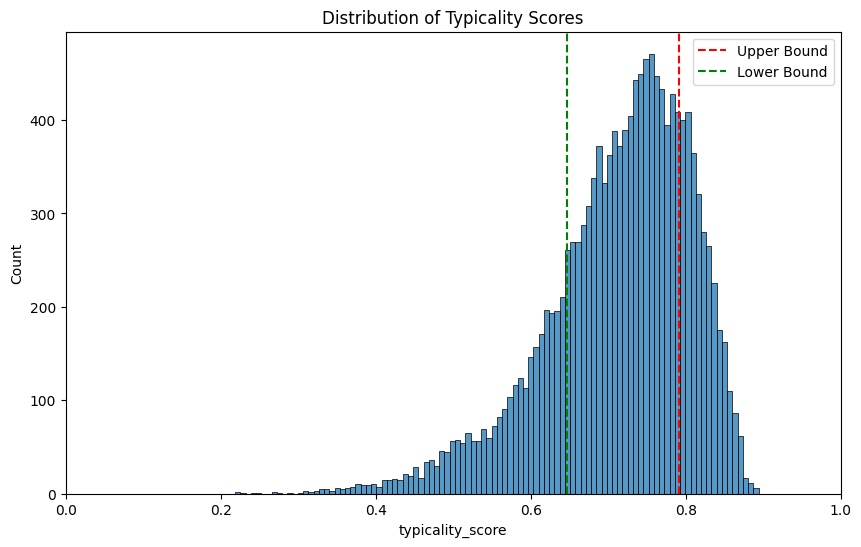

In [6]:
n = 3000
upper_bound = meta.typicality_score.nlargest(n).min()
lower_bound = meta.typicality_score.nsmallest(n).max()

# Plot distribution of typicality scores
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(meta.typicality_score, bins=100, ax=ax)
ax.set_xlim(0, 1)
ax.set_title("Distribution of Typicality Scores")

ax.axvline(upper_bound, color='red', linestyle='--', label='Upper Bound')
ax.axvline(lower_bound, color='green', linestyle='--', label='Lower Bound')

plt.legend()
plt.show()


In [7]:

summary_stats = {}
for n in [1000,2000,3000,4000,5000]:
    upper_bound = meta.typicality_score.nlargest(n).min()
    lower_bound = meta.typicality_score.nsmallest(n).max()

    meta_copy = meta.copy()
    # Assign 0/1 labels based on typicality scores
    meta_copy.loc[meta_copy.typicality_score >= upper_bound, 'label'] = 1
    meta_copy.loc[meta_copy.typicality_score <= lower_bound, 'label'] = 0


    # Drop unlabeled samples
    subset = meta_copy.dropna(subset=['label']).copy()
    subset.label = subset.label.astype(int)

    # Crate target
    target = np.array(subset.label).reshape(-1, 1)

    # Subset latents
    latents_subset = [latents[sku].squeeze(0) for sku in subset.sku]



    # Save everything
    os.makedirs(f"{save_path}/{n}/", exist_ok=True)

    # Concatenate all dimensions and save
    latents_concatenated = torch.stack([elem.flatten() for elem in latents_subset])
    np.save(f"{save_path}/{n}/latents_concatenated.npy", latents_concatenated.numpy())
    np.save(f"{save_path}/{n}/target.npy", target)
    subset.to_csv(f'{save_path}/{n}/metadata.csv', index=False)

    summary_stats[n] = {
        'num_samples': target.shape[0],
        'num_positives': target.sum(),
        'num_negatives': (1 - target).sum()
    }

# Save summary stats
stats = pd.DataFrame(summary_stats).T
stats.to_csv(f"{save_path}//summary_stats.csv")

In [8]:
stats

,num_samples,num_positives,num_negatives
1000,2000,1000,1000
2000,4000,2000,2000
3000,6000,3000,3000
4000,8000,4000,4000
5000,10000,5000,5000
